# **Import Modules & Libraries**

In [ ]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
# For optimizing a function we are going to use torch.optim which is a package, implements numerous optimization algorithms.
from torch.optim import Adam
# Using TensorBoard in PyTorch to evaluate the model
from tensorflow import summary

MNIST is a dataset consisting of handwritten images that are normalized and center-cropped. It has over 60,000 training images and 10,000 test images. This is one of the most-used datasets for learning and experimenting purposes.

In [ ]:
from torchvision.datasets import MNIST


Image transformation is a process to change the original values of image pixels to a set of new values. One type of transformation that we do on images is to transform an image into a PyTorch tensor. When an image is transformed into a PyTorch tensor, the pixel values are scaled between 0.0 and 1.0. In PyTorch, this transformation can be done using torchvision.transforms.ToTensor(). It converts the PIL image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]. 

The normalization of images is a very good practice when we work with deep neural networks. Normalizing the images means transforming the images into such values that the mean and standard deviation of the image become 0.0 and 1.0 respectively.

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize

*   random_split to split a given dataset into more than one (sub)datasets. This is handy since it can be used to create training, validation, and test sets. Use training set for training purposes. Use validation set during training to check underfitting and overfitting.
*   Data loading is one of the first steps in building a Deep Learning pipeline, or training a model. This task becomes more challenging when the complexity of the data increases. In this section, we will learn about the DataLoader class in PyTorch that helps us to load and iterate over elements in a dataset. let's now discuss in detail the parameters that the DataLoader class accepts: DataLoader( dataset,batch_size=1,shuffle=False,num_workers=0, collate_fn=None,pin_memory=False)
      

     1.   **Dataset:** The first parameter in the DataLoader class is the dataset. This is where we load the data from.
     2.   **Batching the data:** batch_size refers to the number of training samples used in one iteration. Usually we split our data into training and testing sets, and we may have different batch sizes for each.
     3.   **Shuffling the data:** shuffle is another argument passed to the DataLoader class. The argument takes in a Boolean value (True/False). If shuffle is set to True, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.
     4.   **Allowing multi-processing:** As deep learning involves training models with a lot of data, running only single processes ends up taking a lot of time.
     5.   **Merging datasets:** The collate_fn argument is used if we want to merge datasets. This argument is optional, and mostly used when batches are loaded from map-styled datasets.
     6.  **Loading data on CUDA tensors:** You can directly load datasets as CUDA tensors using the pin_memory argument. It is an optional parameter that takes in a Boolean value; if set to True, the DataLoader class copies Tensors into CUDA-pinned memory before returning them.



     



In [ ]:
from torch.utils.data import random_split, DataLoader

**Tensorboard** : It is an open source toolkit which enables us to understand training progress and improve model performance by updating the hyperparameters. TensorBoard toolkit displays a dashboard where the logs can be visualized as graphs, images, histograms, embeddings, text etc.

In [ ]:
%load_ext tensorboard
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)

# **Data Preparation**

In [ ]:
def prepare_data(batch_size):
  # transform to normalize the data
  transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
  
  # Download and load the training and test datasets
  trainset = MNIST(root='MNIST', download=True, train=True, transform=transform)
  testset = MNIST(root='MNIST', download=True, train=False, transform=transform)

  trainset_size = round(len(trainset) * 0.8)
  validset_size = len(trainset) - trainset_size
  trainset, validset = random_split(trainset, [trainset_size, validset_size])

  train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  valid_dl = DataLoader(validset, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

  return train_dl, valid_dl, test_dl

# **Model Definition**
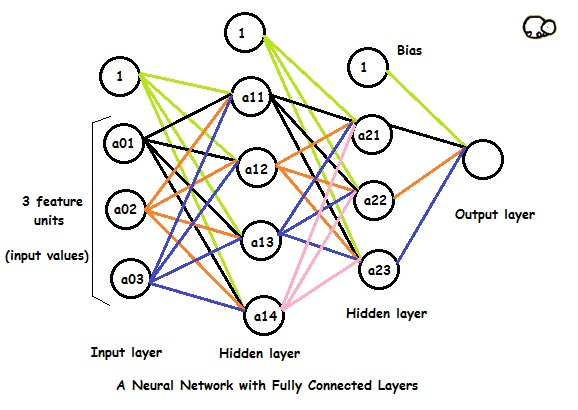



In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, N1, N2, output_dim):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim,N1)
    self.fc2 = nn.Linear(N1, N2)
    self.fc3 = nn.Linear(N2, output_dim)
    self.dropout = nn.Dropout(0.2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    out=self.dropout(self.relu(self.fc1(x)))
    out=self.dropout(self.relu(self.fc2(out)))
    out=self.fc3(out)        
    return out

# Early Stopping to Halt the Training of Neural Networks 
A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.
Early stopping requires that a validation dataset is evaluated during training.

# **Mini-Batch Taining with Early Stopping**

In [ ]:
# compute the loss on validation set for early stopping
def validation(model, device, valid_dl, criterion): # device = cpu ou cuda , criterion= Mean squared error MSE for regression, Binary Cross Entropy BCE for binary classification and Cross Entropy for multi classification
  model.eval() # Sets the module in evaluation mode , c'est à dire training = False
  loss_total = 0
  with torch.no_grad(): 
    """every time you do a forward pass with a torch model (and you are not in a torch.no_grad() block), then gradients will accumulate for the weight tensors of the model, 
  so that when you go to do the backward pass, the gradients are already there and just need to be multiplied that's why we use with torch.no_grad"""
    for data in valid_dl:
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs.view(inputs.shape[0], -1)) 
      """ Because the input layer of an MLP takes 1D tensors, we need to reshape 2-dimensional MNIST image data into 1-dimensional data. This process is technically called flattening the image. """
      loss = criterion(outputs, labels)
      loss_total += loss.item()
  
  return loss_total / len(valid_dl)

In [ ]:
# Training 
def train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl):
  last_loss = 100; patience = 2; triggertimes = 0  
  """ patience: Number of epochs with no improvement after which training will be stopped
      triggertimes: combine on va attendre aprés les 2 epochs """    
  for epoch in range(1,epochs+1):
    model.train() # Sets the module in traininng mode
    for batch_idx, data in enumerate(train_dl):
      inputs = data[0].to(device)
      labels = data[1].to(device)
      # Zero the gradients
      optimizer.zero_grad()
      # Forward and backward propagation
      outputs = model(inputs.view(inputs.shape[0], -1))
      loss = criterion(outputs, labels)     
      loss.backward()
      optimizer.step() # mettre à jour les paramètres
      # Show progress
      if batch_idx % 100 == 0 or batch_idx == len(train_dl):
        print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, batch_idx, len(train_dl), loss.item()))
    
    with train_summary_writer.as_default():
      summary.scalar('loss', loss.item(), step=epoch)

    # Early stopping
    current_loss = validation(model, device, valid_dl, criterion)
    if current_loss > last_loss:
      triggertimes += 1 
      print('trigger times', triggertimes)       
    if triggertimes >= patience:
      print('Perform Early stopping!')
      return model
    else:
      trigger_times = 0 
      print('trigger times', triggertimes)          
    last_loss = current_loss
    
  return model

# **Evaluation** 
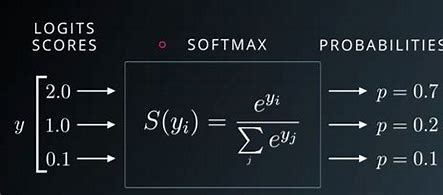

In [ ]:
def evaluation(model, device, test_dl):
  model.eval()
  total = 0.0; correct = 0.0 
  with torch.no_grad():
    for data in test_dl:
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs.view(inputs.shape[0], -1))
      _, predicted = torch.max(outputs.data, 1)      
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = correct/total
  return accuracy

# **Main Function**

In [ ]:
def main(epochs=100, batch_size=64, lr=0.002):  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = nn.CrossEntropyLoss()
  model = MLP(784, 128, 64, 10)
  model = model.to(device) # Move model before creating optimizer
  print(model)
  optimizer = Adam(model.parameters(), lr=lr)
  # Data Preparation
  train_dl, valid_dl, test_dl = prepare_data(batch_size)
  # Training
  model = train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl)
  # Evaluation
  acc = evaluation(model, device, test_dl)
  print('Accuracy', acc)
  torch.save(model.state_dict(),"mnist_mlp.pt")

if __name__ == '__main__':
  main()

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

[1/100, 0/750] loss: 2.3051887
[1/100, 100/750] loss: 0.60564351
[1/100, 200/750] loss: 0.59228253
[1/100, 300/750] loss: 0.3458885
[1/100, 400/750] loss: 0.45217344
[1/100, 500/750] loss: 0.35819328
[1/100, 600/750] loss: 0.27754235
[1/100, 700/750] loss: 0.28661379
trigger times 0
[2/100, 0/750] loss: 0.44457212
[2/100, 100/750] loss: 0.12767448
[2/100, 200/750] loss: 0.17790346
[2/100, 300/750] loss: 0.22648773
[2/100, 400/750] loss: 0.19986978
[2/100, 500/750] loss: 0.36824247
[2/100, 600/750] loss: 0.22191919
[2/100, 700/750] loss: 0.12858176
trigger times 0
[3/100, 0/750] loss: 0.25636581
[3/100, 100/750] loss: 0.19403183
[3/100, 200/750] loss: 0.10294513
[3/100, 300/750] loss: 0.19459686
[3/100, 400/750] loss: 0.27015841
[3/100, 500/750] loss: 0.23754428
[3/100, 600/750] loss: 0.3079119
[3/100, 700/750] loss: 0.17012209
trigger times 0
[4/100, 0/750] loss: 0.098193623
[4/100, 100/750] loss: 0.46139905
[4/10

In [ ]:
%tensorboard --logdir logs/tensorboard

<IPython.core.display.Javascript object>

Reusing TensorBoard on port 6006 (pid 756), started 0:00:00 ago. (Use '!kill 756' to kill it.)

<IPython.core.display.Javascript object>